In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold,cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import category_encoders as ce
import optuna
from optuna.integration import OptunaSearchCV
from skopt import BayesSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from skopt.space import Categorical, Integer
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('ml_data.csv')

In [3]:
df.drop(columns=['PROP_ID','PROPERTY_TYPE','Price_per_sqft','TOTAL_FLOOR','SOCIETY_NAME'], inplace=True)

In [4]:
df.sample()

,location,BEDROOM_NUM,BALCONY_NUM,AREA,PRICE,AGE,FURNISH,amenity_luxury,FLOOR_NUM
4209,Rajarhat,2.0,1.0,780,0.32,New Property,Fully furnished,338.0,3


In [5]:
df['amenity_luxury'] = df['amenity_luxury'].apply(lambda x: 'Low' if x <=200 else 'Medium' if x <= 500 else 'High')

In [6]:
df['FLOOR_NUM'] = df['FLOOR_NUM'].apply(lambda x : 'Low Floor' if x <= 2 else 'Mid Floor' if x <= 10 else 'High Floor')

In [8]:
x = df.drop(columns=['PRICE'])

In [9]:
x

,location,BEDROOM_NUM,BALCONY_NUM,AREA,AGE,FURNISH,amenity_luxury,FLOOR_NUM
0,Madhyamgram,2.0,1.0,920,Old Property,Unfurnished,Medium,Low Floor
1,Garia,1.0,1.0,535,Old Property,Unfurnished,Medium,Low Floor
2,Rajarhat,4.0,2.0,1940,Old Property,Unfurnished,Medium,Low Floor
3,Rajarhat,2.0,1.0,910,Old Property,Unfurnished,Medium,Low Floor
4,New Town,3.0,1.0,1163,Old Property,Unfurnished,Medium,Low Floor
...,...,...,...,...,...,...,...,...
5143,Behala,2.0,1.0,730,Relatively New Property,Fully furnished,Medium,Low Floor
5144,New Alipore,3.0,1.0,2000,Moderately Old,Luxury furnished,Low,Low Floor
5145,Chak Garia,3.0,2.0,1843,New Property,Luxury furnished,Low,High Floor
5146,Chak Garia,3.0,2.0,2079,New Property,Luxury furnished,Low,Mid Floor


In [12]:
df.columns

Index(['location', 'BEDROOM_NUM', 'BALCONY_NUM', 'AREA', 'PRICE', 'AGE',
       'FURNISH', 'amenity_luxury', 'FLOOR_NUM'],
      dtype='object')

In [24]:
location_suggestion = []
for i in x['FLOOR_NUM']:
    location_suggestion.append(i)
location_suggestion = list(set(location_suggestion))
new_list = []
for i in location_suggestion:
    new_list.append(i)
new_list

['High Floor', 'Mid Floor', 'Low Floor']

In [10]:
y = df['PRICE']

In [11]:
y_transform = np.log1p(y)

In [13]:
columns_ordinal_encode = ['AGE','FURNISH','amenity_luxury']

In [14]:
encoder = OrdinalEncoder()
encoder.fit(x[columns_ordinal_encode])

OrdinalEncoder()

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num' ,  StandardScaler(),['BEDROOM_NUM','BALCONY_NUM','AREA']),
        ('cat1',OrdinalEncoder(categories=encoder.categories_), columns_ordinal_encode),
        ('cat2', OneHotEncoder(drop='first',sparse_output=False,handle_unknown='ignore'),['FLOOR_NUM']),
        ('target_enc', ce.TargetEncoder(), ['location'])
    ], remainder= 'passthrough'
)


pipeline = Pipeline([
    ('preprocessor' , preprocessor),
    ('regressor', XGBRegressor())
])


kfold = KFold(n_splits=10,shuffle=True,random_state=42)
scores = cross_val_score(pipeline,x,y_transform,scoring='r2',cv=kfold)

In [16]:
scores.mean()

0.8964044064936403

In [17]:
scores.std()

0.0122990822108887

In [19]:
def scorer(model):

    output = []

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, x, y_transform, cv=kfold, scoring='r2')

    output.append(scores.mean())

    X_train, X_test, y_train, y_test = train_test_split(x,y_transform,test_size=0.2,random_state=42)

    pipeline.fit(X_train,y_train)

    y_pred = pipeline.predict(X_test)

    y_pred = np.expm1(y_pred)

    output.append(mean_absolute_error(np.expm1(y_test),y_pred))

    return output


In [21]:
scorer(ExtraTreesRegressor(n_jobs=-1))

[0.8970615226404695, 0.17152880051976863]

In [45]:

x = df.drop(columns=['PRICE'])
y = df['PRICE']
y_transform = np.log1p(y)

encoder = OrdinalEncoder()
encoder.fit(x[columns_ordinal_encode])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['BEDROOM_NUM', 'BALCONY_NUM', 'AREA']),
        ('cat1', OrdinalEncoder(categories=encoder.categories_), columns_ordinal_encode),
        ('cat2', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['FLOOR_NUM']),
        ('target_enc', ce.TargetEncoder(), ['location'])
    ], remainder='passthrough'
)

Regressor = XGBRegressor()

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Regressor)
])

# Cross-Validation
cv_scores = cross_val_score(pipeline, x, y_transform, scoring='r2', cv=10)
print(f"Cross-Validation Mean R² Score: {np.mean(cv_scores)}")

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y_transform, test_size=0.2, random_state=42)
pipeline.fit(x_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(x_test)

# Calculate the R² score
test_score = pipeline.score(x_test, y_test)
print(f"Train Test split Test Set R² Score on x_test, y_test: {test_score}")

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))  # Inverse transform the predictions
print(f"Test Set MAE y_test vs y_pred: {mae}")


Cross-Validation Mean R² Score: 0.8726399384654158
Train Test split Test Set R² Score on x_test, y_test: 0.9095450480498388
Test Set MAE y_test vs y_pred: 0.171856784369471


In [46]:


# Assuming df is your DataFrame
x = df.drop(columns=['PRICE'])
y = df['PRICE']
y_transform = np.log1p(y)

# Fit OrdinalEncoder
encoder = OrdinalEncoder()
encoder.fit(x[columns_ordinal_encode])

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['BEDROOM_NUM', 'BALCONY_NUM', 'AREA']),
        ('cat1', OrdinalEncoder(categories=encoder.categories_), columns_ordinal_encode),
        ('cat2', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['FLOOR_NUM']),
        ('target_enc', ce.TargetEncoder(), ['location'])
    ], remainder='passthrough'
)

# Define the base XGBRegressor
Regressor = XGBRegressor(verbosity=0, n_jobs=-1)

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Regressor)
])

# Refined Search Space for Bayesian Optimization
param_grid_refined = {
    'regressor__n_estimators': (400, 700),  # Narrower range based on past results
    'regressor__max_depth': (5, 7),
    'regressor__learning_rate': (0.01, 0.1, 'log-uniform'),
    'regressor__subsample': (0.7, 1.0),
    'regressor__colsample_bytree': (0.7, 0.9),
    'regressor__gamma': (0.01, 0.1)  # Narrowed gamma range
}

# Define the Bayesian Optimization search
bayes_search_refined = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_grid_refined,
    scoring='r2',
    cv=10,
    n_jobs=-1,
    n_iter=100,  # Increased number of iterations for a more thorough search
    random_state=42,
    verbose=0  # Set to 1 or 2 for more verbose output
)

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y_transform, test_size=0.2, random_state=42)

# Fit the Bayesian search
bayes_search_refined.fit(x_train, y_train)

# Print the best hyperparameters
print(f"Refined Best Hyperparameters: {bayes_search_refined.best_params_}")
print(f"Refined Best Cross-Validation R² Score: {bayes_search_refined.best_score_}")

# Evaluate on the test set using the best model
test_score_refined = bayes_search_refined.score(x_test, y_test)
print(f"Refined Test Set R² Score with Best Model: {test_score_refined}")

# Make predictions on the test set
y_pred_refined = bayes_search_refined.predict(x_test)

# Calculate the Mean Absolute Error (MAE)
mae_refined = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_refined))  # Inverse transform the predictions
print(f"Refined Test Set MAE with Best Model: {mae_refined}")


Refined Best Hyperparameters: OrderedDict([('regressor__colsample_bytree', 0.7), ('regressor__gamma', 0.01), ('regressor__learning_rate', 0.1), ('regressor__max_depth', 6), ('regressor__n_estimators', 608), ('regressor__subsample', 0.7)])
Refined Best Cross-Validation R² Score: 0.892516634997712
Refined Test Set R² Score with Best Model: 0.909746193940739
Refined Test Set MAE with Best Model: 0.17639804907389056


In [47]:


# Assuming df is your DataFrame
x = df.drop(columns=['PRICE'])
y = df['PRICE']
y_transform = np.log1p(y)

# OrdinalEncoder fit
encoder = OrdinalEncoder()
encoder.fit(x[columns_ordinal_encode])

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['BEDROOM_NUM', 'BALCONY_NUM', 'AREA']),
        ('cat1', OrdinalEncoder(categories=encoder.categories_), columns_ordinal_encode),
        ('cat2', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['FLOOR_NUM']),
        ('target_enc', ce.TargetEncoder(), ['location'])
    ], remainder='passthrough'
)

# Define the base XGBRegressor
Regressor = XGBRegressor(verbosity=0, n_jobs=-1)

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Regressor)
])

# Define the parameter space for Bayesian Optimization
param_grid = {
    'regressor__n_estimators': (200, 800),
    'regressor__max_depth': (3, 8),
    'regressor__learning_rate': (0.01, 0.2, 'log-uniform'),  # log-uniform for learning_rate
    'regressor__subsample': (0.6, 1.0),
    'regressor__colsample_bytree': (0.6, 1.0),
    'regressor__gamma': (0, 0.3)
}

# Define the Bayesian Optimization search
bayes_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_grid,
    scoring='r2',
    cv=10,
    n_jobs=-1,
    n_iter=50,  # Number of parameter settings that are sampled
    random_state=42,
    verbose=0  # Set to 1 or 2 for more verbose output
)

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y_transform, test_size=0.2, random_state=42)

# Fit the Bayesian search
bayes_search.fit(x_train, y_train)

# Print the best hyperparameters
print(f"Best Hyperparameters: {bayes_search.best_params_}")
print(f"Best Cross-Validation R² Score: {bayes_search.best_score_}")

# Evaluate on the test set using the best model
test_score = bayes_search.score(x_test, y_test)
print(f"Test Set R² Score with Best Model: {test_score}")

# Make predictions on the test set
y_pred = bayes_search.predict(x_test)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))  # Inverse transform the predictions
print(f"Test Set MAE with Best Model: {mae}")


Best Hyperparameters: OrderedDict([('regressor__colsample_bytree', 0.6962269683726227), ('regressor__gamma', 4.974324315087931e-05), ('regressor__learning_rate', 0.062193215647129006), ('regressor__max_depth', 5), ('regressor__n_estimators', 787), ('regressor__subsample', 0.9507304440056652)])
Best Cross-Validation R² Score: 0.894921737173412
Test Set R² Score with Best Model: 0.91303268868149
Test Set MAE with Best Model: 0.16988374096155165


In [32]:
df.shape

(5148, 9)

In [31]:
# Fit on the entire dataset
encoder = OrdinalEncoder()
encoder.fit(x[columns_ordinal_encode])

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['BEDROOM_NUM', 'BALCONY_NUM', 'AREA']),
        ('cat1', OrdinalEncoder(categories=encoder.categories_), columns_ordinal_encode),
        ('cat2', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['FLOOR_NUM']),
        ('target_enc', ce.TargetEncoder(), ['location'])
    ], remainder='passthrough'
)


In [57]:


final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(verbosity=0,
                               n_jobs=-1,
                               colsample_bytree = 0.6962269683726227,
                               gamma=  4.974324315087931e-05,
                               learning_rate = 0.062193215647129006,
                               max_depth = 5 ,
                               n_estimators =787,
                               subsample = 0.9507304440056652))
])

x_train, x_test, y_train, y_test = train_test_split(x, y_transform, test_size=0.01, random_state=42)
final_pipeline.fit(x_train,y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['BEDROOM_NUM', 'BALCONY_NUM',
                                                   'AREA']),
                                                 ('cat1',
                                                  OrdinalEncoder(categories=[array(['Moderately Old', 'New Property', 'Old Property',
       'Relatively New Property'], dtype=object),
                                                                             array(['Fully furnished', 'Luxury furnished', 'Semi-furnished',
       'Unfurnished'], d...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.062193215647129006, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=787, n_jobs=-1,
                              num_parallel_tree=None, random_state=None, ...))])

In [35]:
x_test

,location,BEDROOM_NUM,BALCONY_NUM,AREA,AGE,FURNISH,amenity_luxury,FLOOR_NUM
1176,Bansdroni,3.0,1.0,1162,Relatively New Property,Fully furnished,Medium,Mid Floor
3362,Kestopur,2.0,1.0,711,New Property,Fully furnished,Low,Low Floor
1090,New Town,4.0,4.0,1925,Old Property,Fully furnished,High,High Floor
4815,Garia,2.0,2.0,881,Old Property,Fully furnished,Low,Mid Floor
4373,Joka,3.0,3.0,1129,Relatively New Property,Fully furnished,High,Mid Floor
279,Lake Town,2.0,1.0,765,Relatively New Property,Semi-furnished,High,Low Floor
996,Madhyamgram,4.0,2.0,1588,Old Property,Unfurnished,Medium,Low Floor
584,Majarhati,3.0,1.0,814,Old Property,Fully furnished,Medium,Mid Floor
1485,Kamalgazi,3.0,1.0,1530,Relatively New Property,Luxury furnished,Medium,Mid Floor
3922,Minto Park,3.0,0.0,2329,Old Property,Fully furnished,Medium,Mid Floor


In [59]:
# Access row with index 1176
df.loc[[4005]]


,location,BEDROOM_NUM,BALCONY_NUM,AREA,PRICE,AGE,FURNISH,amenity_luxury,FLOOR_NUM
4005,Dover Terrace,2.0,1.0,1356,1.42,Relatively New Property,Fully furnished,Low,Mid Floor


In [60]:
# Assuming `x_test` has fewer rows, use the first row or a valid index
np.expm1(final_pipeline.predict(x_test.loc[[4005]]))


array([1.1723874], dtype=float32)

In [18]:
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(verbosity=0,
                               n_jobs=-1,
                               colsample_bytree = 0.6962269683726227,
                               gamma=  4.974324315087931e-05,
                               learning_rate = 0.062193215647129006,
                               max_depth = 5 ,
                               n_estimators =787,
                               subsample = 0.9507304440056652))
])

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y_transform, test_size=0.01, random_state=42)
final_pipeline.fit(x_train, y_train)

# Initialize a counter
operation_count = 0

# Iterate over the indices of x_test
for idx in x_test.index:
    actual_price = np.expm1(y_test.loc[idx])
    predicted_price = np.expm1(final_pipeline.predict(x_test.loc[[idx]]))[0]
    residual = actual_price - predicted_price

    # Print the details
    print(f"Actual Price: {actual_price:.2f},Predicted Price: {predicted_price:.2f}, Predicted Price: {predicted_price - 0.10:.2f} to {predicted_price + 0.10:.2f}, Residual: {residual:.2f}")

    # Increment the counter
    operation_count += 1

# Print the total number of operations
print(f"Total number of operations: {operation_count}")


Actual Price: 0.72,Predicted Price: 0.43, Predicted Price: 0.33 to 0.53, Residual: 0.29
Actual Price: 0.24,Predicted Price: 0.25, Predicted Price: 0.15 to 0.35, Residual: -0.01
Actual Price: 1.48,Predicted Price: 1.69, Predicted Price: 1.59 to 1.79, Residual: -0.21
Actual Price: 0.55,Predicted Price: 0.41, Predicted Price: 0.31 to 0.51, Residual: 0.14
Actual Price: 0.64,Predicted Price: 0.66, Predicted Price: 0.56 to 0.76, Residual: -0.02
Actual Price: 0.38,Predicted Price: 0.45, Predicted Price: 0.35 to 0.55, Residual: -0.07
Actual Price: 0.70,Predicted Price: 0.75, Predicted Price: 0.65 to 0.85, Residual: -0.05
Actual Price: 0.76,Predicted Price: 0.67, Predicted Price: 0.57 to 0.77, Residual: 0.09
Actual Price: 0.84,Predicted Price: 0.75, Predicted Price: 0.65 to 0.85, Residual: 0.09
Actual Price: 3.20,Predicted Price: 3.69, Predicted Price: 3.59 to 3.79, Residual: -0.49
Actual Price: 1.32,Predicted Price: 1.31, Predicted Price: 1.21 to 1.41, Residual: 0.01
Actual Price: 0.33,Predict

# Extra Trees:

In [19]:


# Assuming df is your DataFrame
x = df.drop(columns=['PRICE'])
y = df['PRICE']
y_transform = np.log1p(y)



encoder = OrdinalEncoder()
encoder.fit(x[columns_ordinal_encode])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['BEDROOM_NUM', 'BALCONY_NUM', 'AREA']),
        ('cat1', OrdinalEncoder(categories=encoder.categories_), columns_ordinal_encode),
        ('cat2', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['FLOOR_NUM']),
        ('target_enc', ce.TargetEncoder(), ['location'])
    ], remainder='passthrough'
)

# Initialize ExtraTreesRegressor
Regressor = ExtraTreesRegressor()

# Define the pipeline
pipeline_etratrees = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Regressor)
])

# Cross-Validation
cv_scores = cross_val_score(pipeline_etratrees, x, y_transform, scoring='r2', cv=10)
print(f"Cross-Validation Mean R² Score: {np.mean(cv_scores)}")

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y_transform, test_size=0.2, random_state=42)
pipeline_etratrees.fit(x_train, y_train)

# Predict on the test set
y_pred = pipeline_etratrees.predict(x_test)

# Calculate the R² score
test_score = pipeline_etratrees.score(x_test, y_test)
print(f"Train-Test Split Test Set R² Score: {test_score}")

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))  # Inverse transform the predictions
print(f"Test Set MAE: {mae}")

# Define the parameter space for Bayesian Optimization
param_space = {
    'regressor__n_estimators': Integer(100, 500),
    'regressor__max_depth': Categorical([None] + list(range(1, 31))),
    'regressor__min_samples_split': Integer(2, 10),
    'regressor__min_samples_leaf': Integer(1, 4),
    'regressor__max_features': Categorical(['sqrt', 'log2', None])
}

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=pipeline_etratrees,
    search_spaces=param_space,
    scoring='r2',
    cv=10,
    n_jobs=-1,
    n_iter=100,  # Adjust the number of iterations as needed
    random_state=42
)

# Fit Bayesian Search
bayes_search.fit(x_train, y_train)

# Print the best hyperparameters
print(f"Best Hyperparameters: {bayes_search.best_params_}")
print(f"Best Cross-Validation R² Score: {bayes_search.best_score_}")

# Evaluate on the test set using the best model
best_pipeline = bayes_search.best_estimator_
test_score = best_pipeline.score(x_test, y_test)
print(f"Test Set R² Score with Best Model: {test_score}")

# Make predictions and calculate MAE
y_pred = best_pipeline.predict(x_test)
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
print(f"Test Set MAE with Best Model: {mae}")


KeyboardInterrupt: 

In [62]:
# Best Score

# Assuming df is your DataFrame
x = df.drop(columns=['PRICE'])
y = df['PRICE']
y_transform = np.log1p(y)

encoder = OrdinalEncoder()
encoder.fit(x[columns_ordinal_encode])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['BEDROOM_NUM', 'BALCONY_NUM', 'AREA']),
        ('cat1', OrdinalEncoder(categories=encoder.categories_), columns_ordinal_encode),
        ('cat2', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['FLOOR_NUM']),
        ('target_enc', ce.TargetEncoder(), ['location'])
    ], remainder='passthrough'
)

# Initialize ExtraTreesRegressor
Regressor = ExtraTreesRegressor()

# Define the pipeline
pipeline_etratrees = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Regressor)
])

# Cross-Validation
cv_scores = cross_val_score(pipeline_etratrees, x, y_transform, scoring='r2', cv=10)
print(f"Cross-Validation Mean R² Score: {np.mean(cv_scores)}")

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y_transform, test_size=0.2, random_state=42)
pipeline_etratrees.fit(x_train, y_train)

# Predict on the test set
y_pred = pipeline_etratrees.predict(x_test)

# Calculate the R² score
test_score = pipeline_etratrees.score(x_test, y_test)
print(f"Train Test split Test Set R² Score: {test_score}")

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))  # Inverse transform the predictions
print(f"Test Set MAE: {mae}")

# Define the parameter space for Bayesian Optimization
param_space = {
    'regressor__n_estimators': (100, 500),  # Number of trees
    'regressor__max_depth': (None, 10, 20, 30),
    'regressor__min_samples_split': (2, 10),
    'regressor__min_samples_leaf': (1, 4),
    'regressor__max_features': ['sqrt', 'log2', None]  # Options for max_features
}

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=pipeline_etratrees,
    search_spaces=param_space,
    scoring='r2',
    cv=10,
    n_jobs=-1,
    n_iter=50,
    random_state=42
)

# Fit Bayesian Search
bayes_search.fit(x_train, y_train)

# Print the best hyperparameters
print(f"Best Hyperparameters: {bayes_search.best_params_}")
print(f"Best Cross-Validation R² Score: {bayes_search.best_score_}")

# Evaluate on the test set using the best model
best_pipeline = bayes_search.best_estimator_
test_score = best_pipeline.score(x_test, y_test)
print(f"Test Set R² Score with Best Model: {test_score}")

# Make predictions and calculate MAE
y_pred = best_pipeline.predict(x_test)
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
print(f"Test Set MAE with Best Model: {mae}")


Cross-Validation Mean R² Score: 0.8729169141466192
Train Test split Test Set R² Score: 0.8996186873873011
Test Set MAE: 0.17232182902719734
Best Hyperparameters: OrderedDict([('regressor__max_depth', 20), ('regressor__max_features', None), ('regressor__min_samples_leaf', 1), ('regressor__min_samples_split', 5), ('regressor__n_estimators', 500)])
Best Cross-Validation R² Score: 0.8891749820753942
Test Set R² Score with Best Model: 0.9023337688582411
Test Set MAE with Best Model: 0.17242704175436296


In [22]:
Extratrees_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ExtraTreesRegressor(
        max_depth=20,
        max_features=None,
        min_samples_leaf=1,
        min_samples_split=5,
        n_estimators=500
    ))
])

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y_transform, test_size=0.01, random_state=42)
Extratrees_pipeline.fit(x_train, y_train)

# Initialize a counter
operation_count = 0

# Iterate over the indices of x_test
for idx in x_test.index:
    actual_price = np.expm1(y_test.loc[idx])
    predicted_price = np.expm1(Extratrees_pipeline.predict(x_test.loc[[idx]]))[0]
    residual = actual_price - predicted_price

    # Print the details
    print(f"Actual Price: {actual_price:.2f}, Rage: {predicted_price-.13:.2f} to {predicted_price+.13:.2f}, Predicted Price: {predicted_price:.2f},  Residual: {residual:.2f}")

    # Increment the counter
    operation_count += 1

# Print the total number of operations
print(f"Total number of operations: {operation_count}")


Actual Price: 0.72, Rage: 0.32 to 0.58, Predicted Price: 0.45,  Residual: 0.27
Actual Price: 0.24, Rage: 0.12 to 0.38, Predicted Price: 0.25,  Residual: -0.01
Actual Price: 1.48, Rage: 1.45 to 1.71, Predicted Price: 1.58,  Residual: -0.10
Actual Price: 0.55, Rage: 0.30 to 0.56, Predicted Price: 0.43,  Residual: 0.12
Actual Price: 0.64, Rage: 0.51 to 0.77, Predicted Price: 0.64,  Residual: -0.00
Actual Price: 0.38, Rage: 0.32 to 0.58, Predicted Price: 0.45,  Residual: -0.07
Actual Price: 0.70, Rage: 0.62 to 0.88, Predicted Price: 0.75,  Residual: -0.05
Actual Price: 0.76, Rage: 0.54 to 0.80, Predicted Price: 0.67,  Residual: 0.09
Actual Price: 0.84, Rage: 0.54 to 0.80, Predicted Price: 0.67,  Residual: 0.17
Actual Price: 3.20, Rage: 3.22 to 3.48, Predicted Price: 3.35,  Residual: -0.15
Actual Price: 1.32, Rage: 1.12 to 1.38, Predicted Price: 1.25,  Residual: 0.07
Actual Price: 0.33, Rage: 0.20 to 0.46, Predicted Price: 0.33,  Residual: -0.00
Actual Price: 2.50, Rage: 1.76 to 2.02, Predi

In [66]:
import pickle

with open('pipeline.pkl', 'wb') as file:
    pickle.dump(Extratrees_pipeline, file)

In [23]:
x_test

,location,BEDROOM_NUM,BALCONY_NUM,AREA,AGE,FURNISH,amenity_luxury,FLOOR_NUM
1176,Bansdroni,3.0,1.0,1162,Relatively New Property,Fully furnished,Medium,Mid Floor
3362,Kestopur,2.0,1.0,711,New Property,Fully furnished,Low,Low Floor
1090,New Town,4.0,4.0,1925,Old Property,Fully furnished,High,High Floor
4815,Garia,2.0,2.0,881,Old Property,Fully furnished,Low,Mid Floor
4373,Joka,3.0,3.0,1129,Relatively New Property,Fully furnished,High,Mid Floor
279,Lake Town,2.0,1.0,765,Relatively New Property,Semi-furnished,High,Low Floor
996,Madhyamgram,4.0,2.0,1588,Old Property,Unfurnished,Medium,Low Floor
584,Majarhati,3.0,1.0,814,Old Property,Fully furnished,Medium,Mid Floor
1485,Kamalgazi,3.0,1.0,1530,Relatively New Property,Luxury furnished,Medium,Mid Floor
3922,Minto Park,3.0,0.0,2329,Old Property,Fully furnished,Medium,Mid Floor


In [9]:
df

,location,BEDROOM_NUM,BALCONY_NUM,AREA,PRICE,AGE,FURNISH,amenity_luxury,FLOOR_NUM
0,Madhyamgram,2.0,1.0,920,0.39,Old Property,Unfurnished,Medium,Low Floor
1,Garia,1.0,1.0,535,0.27,Old Property,Unfurnished,Medium,Low Floor
2,Rajarhat,4.0,2.0,1940,0.92,Old Property,Unfurnished,Medium,Low Floor
3,Rajarhat,2.0,1.0,910,0.42,Old Property,Unfurnished,Medium,Low Floor
4,New Town,3.0,1.0,1163,0.55,Old Property,Unfurnished,Medium,Low Floor
...,...,...,...,...,...,...,...,...,...
5143,Behala,2.0,1.0,730,0.33,Relatively New Property,Fully furnished,Medium,Low Floor
5144,New Alipore,3.0,1.0,2000,1.80,Moderately Old,Luxury furnished,Low,Low Floor
5145,Chak Garia,3.0,2.0,1843,1.55,New Property,Luxury furnished,Low,High Floor
5146,Chak Garia,3.0,2.0,2079,1.75,New Property,Luxury furnished,Low,Mid Floor


In [13]:
import pickle

pickle.dump(df,open('df.pkl','wb'))

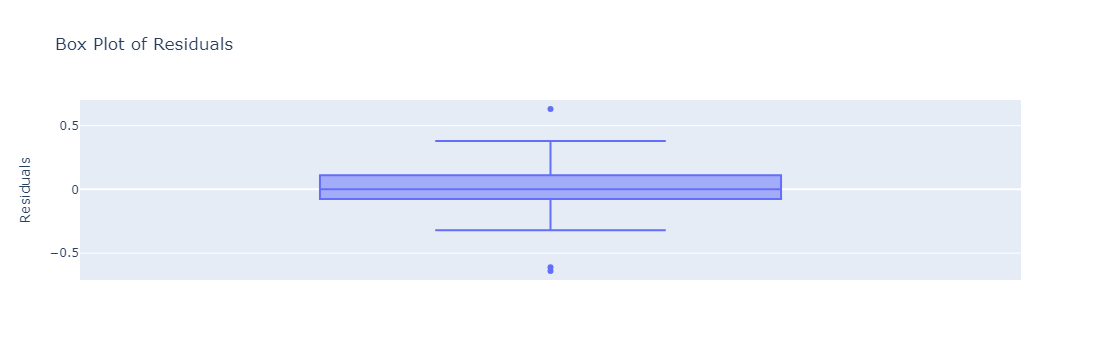

In [11]:
import plotly.express as px


# Your data
data = [0.27, -0.02, -0.11, 0.13, -0.01, -0.08, -0.05, 0.08, 0.16, -0.16, 0.08, 0.00, 
        0.63, 0.38, -0.03, -0.03, -0.00, 0.00, -0.06, 0.12, -0.12, -0.18, -0.21, -0.14, 
        -0.09, 0.20, 0.07, -0.61, -0.64, -0.05, 0.15, -0.02, -0.00, 0.28, -0.22, 
        0.05, -0.05, 0.12, -0.00, 0.01, 0.13, 0.00, -0.04, -0.03, 0.23, -0.00, -0.10, 
        -0.32, 0.25, 0.03, 0.07]

# Create a DataFrame for better visualization and labeling
df = pd.DataFrame(data, columns=['Residuals'])

# Plot the box plot using Plotly
fig = px.box(df, y='Residuals', title="Box Plot of Residuals")

# Show the plot
fig.show()


In [15]:

def calculate_statistics(data):
   
    data = np.array(data)
    
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    # Calculate IQR
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    mean = np.mean(data)
    std = np.std(data)
    
    return {
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Mean': mean,
        'Standard Deviation': std
    }

# Example usage:
data = [0.27, -0.02, -0.11, 0.13, -0.01, -0.08, -0.05, 0.08, 0.16, -0.16, 0.08, 0.00, 
         0.38, -0.03, -0.03, -0.00, 0.00, -0.06, 0.12, -0.12, -0.18, -0.21, -0.14, 
        -0.09, 0.20, 0.07,   -0.05, 0.15, -0.02, -0.00, 0.28, -0.22, 
        0.05, -0.05, 0.12, -0.00, 0.01, 0.13, 0.00, -0.04, -0.03, 0.23, -0.00, -0.10, 
        -0.32, 0.25, 0.03, 0.07]

# Calculate statistics
stats = calculate_statistics(data)
print(stats)


{'Lower Bound': -0.26625000000000004, 'Upper Bound': 0.30375, 'Mean': 0.014375000000000004, 'Standard Deviation': 0.13827668895491146}


In [ ]:
[0.27, -0.02, -0.11, 0.13, -0.01, -0.08, -0.05, 0.08, 0.16, -0.16, 0.08, 0.00, 
         0.38, -0.03, -0.03, -0.00, 0.00, -0.06, 0.12, -0.12, -0.18, -0.21, -0.14, 
        -0.09, 0.20, 0.07,   -0.05, 0.15, -0.02, -0.00, 0.28, -0.22, 
        0.05, -0.05, 0.12, -0.00, 0.01, 0.13, 0.00, -0.04, -0.03, 0.23, -0.00, -0.10, 
        -0.32, 0.25, 0.03, 0.07]